<a href="https://colab.research.google.com/github/RosaR02/Sales-Predictions/blob/main/Project_1_Revisited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Rosa Rocha

##Import Libraries

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

## Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Regression Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn import metrics

## Set global scikit-learn configuration
from sklearn import set_config
## Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}
set_config(transform_output='pandas')

import joblib

from IPython.core.display import clear_output

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)

## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'



##Functions

In [234]:
## Create a function to take the true and predicted values
## and print MAE, MSE, RMSE, and R2 metrics for a model
def eval_regression(y_true, y_pred, name='model'):
  """Takes true targets and predictions from a regression model and prints
  MAE, MSE, RMSE, AND R2 scores
  Set 'name' to name of model and 'train' or 'test' as appropriate"""
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)

  print(f'{name} Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

In [235]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True):
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""

    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train,
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)


    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test,
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)

    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))

    else:
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

#Loading the Data

In [236]:
# or your path here
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sales_predictions.csv')
df.head()


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.3000,Low Fat,0.0160,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,"3,735.1380"
1,DRC01,5.9200,Regular,0.0193,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.5000,Low Fat,0.0168,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,"2,097.2700"
3,FDX07,19.2000,Regular,0.0000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.9300,Low Fat,0.0000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [237]:
df.shape

(8523, 12)

In [238]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [240]:
df.describe(include='number')

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,"7,060.0000","8,523.0000","8,523.0000","8,523.0000","8,523.0000"
mean,12.8576,0.0661,140.9928,"1,997.8319","2,181.2889"
std,4.6435,0.0516,62.2751,8.3718,"1,706.4996"
min,4.5550,0.0000,31.2900,"1,985.0000",33.2900
25%,8.7737,0.0270,93.8265,"1,987.0000",834.2474
50%,12.6000,0.0539,143.0128,"1,999.0000","1,794.3310"
75%,16.8500,0.0946,185.6437,"2,004.0000","3,101.2964"
max,21.3500,0.3284,266.8884,"2,009.0000","13,086.9648"


In [241]:
df.describe(include='object')

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,8523,8523,8523,8523,6113,8523,8523
unique,1559,5,16,10,3,3,4
top,FDW13,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1
freq,10,5089,1232,935,2793,3350,5577


In [242]:
## Display column names
df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

####Duplicates


In [243]:
df.duplicated().sum()

0

In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [245]:
df.isna().sum().sum()

3873

In [246]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

#Clean the Data
*remove unnecessary columns

In [247]:
df.drop(columns='Item_Identifier')

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.3000,Low Fat,0.0160,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,"3,735.1380"
1,5.9200,Regular,0.0193,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.5000,Low Fat,0.0168,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,"2,097.2700"
3,19.2000,Regular,0.0000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.9300,Low Fat,0.0000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...
8518,6.8650,Low Fat,0.0568,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,"2,778.3834"
8519,8.3800,Regular,0.0470,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,10.6000,Low Fat,0.0352,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,"1,193.1136"
8521,7.2100,Regular,0.1452,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,"1,845.5976"


In [248]:
## Display the count of missing values by column
print(df.isna().sum())

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


In [249]:
df['Item_Outlet_Sales'].isna().sum()

0

In [250]:
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [251]:
df.replace({'LF':'Low Fat', 'reg': 'Regular','low fat': 'Low Fat'}, inplace = True)

In [252]:
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [253]:
df['Item_Type'].unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
       'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object)

In [254]:
df['Outlet_Type'].unique()

array(['Supermarket Type1', 'Supermarket Type2', 'Grocery Store',
       'Supermarket Type3'], dtype=object)

In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


##Missing Values

In [256]:
## Display the total number of missing values
print(f'There are {df.isna().sum().sum()} missing values.')

There are 3873 missing values.


In [257]:
## Display the count of missing values by column
print(df.isna().sum())

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


##Ordinal Encode

In [258]:
df['Outlet_Size'].unique()

array(['Medium', nan, 'High', 'Small'], dtype=object)

In [259]:
df.drop

<bound method DataFrame.drop of      Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0              FDA15       9.3000          Low Fat           0.0160   
1              DRC01       5.9200          Regular           0.0193   
2              FDN15      17.5000          Low Fat           0.0168   
3              FDX07      19.2000          Regular           0.0000   
4              NCD19       8.9300          Low Fat           0.0000   
...              ...          ...              ...              ...   
8518           FDF22       6.8650          Low Fat           0.0568   
8519           FDS36       8.3800          Regular           0.0470   
8520           NCJ29      10.6000          Low Fat           0.0352   
8521           FDN46       7.2100          Regular           0.1452   
8522           DRG01      14.8000          Low Fat           0.0449   

                  Item_Type  Item_MRP Outlet_Identifier  \
0                     Dairy  249.8092            OUT049 

In [260]:
#replacement_dictionary = {'Small': '1','Medium':'2', 'High':'3'}

In [261]:
#df['Outlet_Size'].replace(replacement_dictionary, inplace = True)

In [262]:
df['Outlet_Location_Type'].unique()

array(['Tier 1', 'Tier 3', 'Tier 2'], dtype=object)

In [263]:
df['Outlet_Size'].unique()

array(['Medium', nan, 'High', 'Small'], dtype=object)

##Split The Data

In [264]:
# split X and y, we are predicting future sales
#X = df.drop(columns=['Item_Identifier', 'Outlet_Identifier', 'Item_Weight', 'Item_Outlet_Sales'])
#y = df['Item_Outlet_Sales']
# split training and test
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


## Train Test Split
## Make x and y variables
target = "Item_Outlet_Sales"
drop_feats = []

y = df[target].copy()
X = df.drop(columns=[target, *drop_feats]).copy()

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
8269,FDI60,7.2200,Regular,0.0641,Baking Goods,61.2510,OUT010,1998,NaN,Tier 3,Grocery Store
7604,DRD25,6.1350,Low Fat,0.0793,Soft Drinks,111.2860,OUT018,2009,Medium,Tier 3,Supermarket Type2
2762,NCP18,12.1500,Low Fat,0.0286,Household,151.0708,OUT035,2004,Small,Tier 2,Supermarket Type1


In [265]:
X_train.shape

(6392, 11)

In [266]:
X_train.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')

In [267]:
X_train.describe(include='object')

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,6392,6392,6392,6392,4607,6392,6392
unique,1554,2,16,10,3,3,4
top,FDV38,Low Fat,Fruits and Vegetables,OUT049,Medium,Tier 3,Supermarket Type1
freq,9,4157,942,715,2106,2501,4176


In [268]:
X_test.shape

(2131, 11)

##1.Numeric

In [269]:
# Transformers
mean_imputer = SimpleImputer(strategy='mean')
#scaler = StandardScaler()

# Pipeline
num_pipe = make_pipeline(mean_imputer)

# Selector
num_selector = make_column_selector(dtype_include='number')

# Tuple
num_tuple = (num_pipe, num_selector)

##2.Nominal

In [270]:
# Transformers
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
const_imputer = SimpleImputer(strategy='constant', fill_value='missing')
# Pipeline
nominal_pipe = make_pipeline(const_imputer, ohe)
# Selector
nominal_cols = ['Item_Fat_Content', 'Item_Type', 'Outlet_Type']
# Tuple
nominal_tuple = (nominal_pipe, nominal_cols)

##3.Ordinal

In [271]:
# Ordered Category Lists
Outlet_Size_list = ['Small', 'Medium', 'High']
Outlet_Location_Type_list = ['Tier 1', 'Tier 3', 'Tier 2']

# Transformers
ord = OrdinalEncoder(categories=[Outlet_Size_list, Outlet_Location_Type_list])
freq_imputer = SimpleImputer(strategy='most_frequent')
#scaler2 = StandardScaler()
# Pipeline
ord_pipe = make_pipeline(freq_imputer, ord)
# Selector
ord_cols = ['Outlet_Size', 'Outlet_Location_Type']
# Tuple
ord_tuple = (ord_pipe, ord_cols)

In [272]:
# Transformers
mean_imputer = SimpleImputer(strategy='mean')
#scaler = StandardScaler()

# Pipeline
num_pipe = make_pipeline(mean_imputer)

# Selector
num_selector = make_column_selector(dtype_include='number')

# Tuple
num_tuple = (num_pipe, num_selector)

##Create Column Transformer

In [273]:
# Instantiate the make column transformer
preprocessor = make_column_transformer(ord_tuple,
                                       nominal_tuple,
                                       num_tuple,
                                       remainder='drop',
                                       verbose_feature_names_out=False)

##Fit the Column

In [274]:
# Fit the column transformer on the X_train
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Tier '
                                                                              '1',
                                                                              'Tier '
                                                                              '3',
                                                                              'Tier '
                                                                              '2']]))]),
                                 ['Outlet_Size', 'Outlet_Location_Type']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Item_Fat_Content', 'Item_Type',
                                  'Outlet_Type']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7e8fc758d6f0>)],
                  verbose_feature_names_out=False)

##Transform Both Test and Training

In [275]:
# Transform the X_train and the X_test
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)
X_train_proc.head()

,Outlet_Size,Outlet_Location_Type,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,...,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
8269,1.0000,1.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,7.2200,0.0641,61.2510,"1,998.0000"
7604,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,6.1350,0.0793,111.2860,"2,009.0000"
2762,0.0000,2.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,12.1500,0.0286,151.0708,"2,004.0000"
6464,0.0000,2.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,5.9450,0.0930,127.8652,"2,004.0000"
4707,0.0000,2.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,18.2000,0.0663,247.2092,"2,004.0000"


##Check the Results

In [276]:
# Create dataframes from the processed arrays
# First get column names
cols = preprocessor.get_feature_names_out()
# Then transform numpy arrays to dataframes
X_train_df = pd.DataFrame(X_train_proc, columns=cols)
X_train_df

,Outlet_Size,Outlet_Location_Type,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,...,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
8269,1.0000,1.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,7.2200,0.0641,61.2510,"1,998.0000"
7604,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,6.1350,0.0793,111.2860,"2,009.0000"
2762,0.0000,2.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,12.1500,0.0286,151.0708,"2,004.0000"
6464,0.0000,2.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,5.9450,0.0930,127.8652,"2,004.0000"
4707,0.0000,2.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,18.2000,0.0663,247.2092,"2,004.0000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3482,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,12.8226,0.0122,162.7894,"1,985.0000"
8360,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,11.5000,0.0149,174.5080,"1,999.0000"
5929,1.0000,2.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,5.1100,0.0349,161.1210,"2,002.0000"
4220,1.0000,2.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,6.5500,0.0348,157.5288,"2,007.0000"


In [277]:
cols = preprocessor.get_feature_names_out()
# Then transform numpy arrays to dataframes
X_test_df = pd.DataFrame(X_test_proc, columns=cols)
X_test_df

,Outlet_Size,Outlet_Location_Type,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,...,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
8077,1.0000,2.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,15.2500,0.0615,132.2968,"2,007.0000"
2391,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,17.8500,0.0445,127.1020,"1,997.0000"
163,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,7.2700,0.0711,114.2518,"1,997.0000"
4608,1.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,12.8226,0.0751,145.8444,"1,985.0000"
5544,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,13.5000,0.1216,161.6920,"1,998.0000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4816,1.0000,2.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,12.8500,0.0332,172.4422,"2,002.0000"
5323,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,17.2500,0.0373,163.7526,"2,009.0000"
22,0.0000,2.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,14.6000,0.0257,196.5084,"2,004.0000"
4526,1.0000,2.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,13.8500,0.0348,114.2492,"2,007.0000"


In [278]:
# Display the first (5) rows of the dataframe
X_train_df.info()
# Check the shape, datatypes, and missing values


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6392 entries, 8269 to 6682
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Outlet_Size                      6392 non-null   float64
 1   Outlet_Location_Type             6392 non-null   float64
 2   Item_Fat_Content_Low Fat         6392 non-null   float64
 3   Item_Fat_Content_Regular         6392 non-null   float64
 4   Item_Type_Baking Goods           6392 non-null   float64
 5   Item_Type_Breads                 6392 non-null   float64
 6   Item_Type_Breakfast              6392 non-null   float64
 7   Item_Type_Canned                 6392 non-null   float64
 8   Item_Type_Dairy                  6392 non-null   float64
 9   Item_Type_Frozen Foods           6392 non-null   float64
 10  Item_Type_Fruits and Vegetables  6392 non-null   float64
 11  Item_Type_Hard Drinks            6392 non-null   float64
 12  Item_Type_Health 

##Linear Regression

In [279]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [280]:
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Tier '
                                                                              '1',
                                                                              'Tier '
                                                                              '3',
                                                                              'Tier '
                                                                              '2']]))]),
                                 ['Outlet_Size', 'Outlet_Location_Type']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Item_Fat_Content', 'Item_Type',
                                  'Outlet_Type']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7e8fc758d6f0>)],
                  verbose_feature_names_out=False)

In [281]:
## Create an instance of the model
linreg = LinearRegression()


## Fit the model
linreg.fit(X_train_proc, y_train)
evaluate_regression(linreg, X_train_proc, y_train,
                    X_test_proc, y_test)


Split,R^2,MAE,RMSE
Train,0.56,827.51,"1,116.57"
Test,0.56,860.25,"1,165.12"


## Extracting and Visualizing Coefficients

Extracting Coefficients from lin_reg

In [282]:
# access the .coef_
linreg.coef_

array([-1.32831880e+01,  4.94487721e+00, -1.53778449e+01,  1.53778449e+01,
        9.06059616e+00, -7.07331225e+00,  7.07689546e+01,  2.39617255e+01,
       -4.79531862e+01, -2.35840226e+00,  1.55174650e+01,  4.65798588e+01,
       -3.94583080e+01, -6.97248219e+01, -1.24627875e+01,  1.55135234e+01,
        9.48709888e+01, -8.18843729e+00, -1.16587021e+02,  2.75331643e+01,
       -1.71426940e+03,  2.21281618e+02, -1.05116745e+02,  1.59810453e+03,
        1.32487681e+00, -2.68410649e+02,  1.56006184e+01,  7.10731225e-01])

In [283]:
# Intercept
linreg.intercept_

-1508.6260571060375

In [284]:
## Saving the coefficients
coeffs = pd.Series(linreg.coef_, index=linreg.feature_names_in_)
coeffs


Outlet_Size                          -13.2832
Outlet_Location_Type                   4.9449
Item_Fat_Content_Low Fat             -15.3778
Item_Fat_Content_Regular              15.3778
Item_Type_Baking Goods                 9.0606
Item_Type_Breads                      -7.0733
Item_Type_Breakfast                   70.7690
Item_Type_Canned                      23.9617
Item_Type_Dairy                      -47.9532
Item_Type_Frozen Foods                -2.3584
Item_Type_Fruits and Vegetables       15.5175
Item_Type_Hard Drinks                 46.5799
Item_Type_Health and Hygiene         -39.4583
Item_Type_Household                  -69.7248
Item_Type_Meat                       -12.4628
Item_Type_Others                      15.5135
Item_Type_Seafood                     94.8710
Item_Type_Snack Foods                 -8.1884
Item_Type_Soft Drinks               -116.5870
Item_Type_Starchy Foods               27.5332
Outlet_Type_Grocery Store         -1,714.2694
Outlet_Type_Supermarket Type1     

In [285]:
# use .loc to add the intercept to the series
#coeffs.loc['intercept'] = linreg.intercept_
#coeffs

In [307]:
## formatting numbers to not use , thousands sep, and 2 digits floats
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")

In [308]:
## Show formatted coefficients
coeffs

Outlet_Size                          -13.28
Outlet_Location_Type                   4.94
Item_Fat_Content_Low Fat             -15.38
Item_Fat_Content_Regular              15.38
Item_Type_Baking Goods                 9.06
Item_Type_Breads                      -7.07
Item_Type_Breakfast                   70.77
Item_Type_Canned                      23.96
Item_Type_Dairy                      -47.95
Item_Type_Frozen Foods                -2.36
Item_Type_Fruits and Vegetables       15.52
Item_Type_Hard Drinks                 46.58
Item_Type_Health and Hygiene         -39.46
Item_Type_Household                  -69.72
Item_Type_Meat                       -12.46
Item_Type_Others                      15.51
Item_Type_Seafood                     94.87
Item_Type_Snack Foods                 -8.19
Item_Type_Soft Drinks               -116.59
Item_Type_Starchy Foods               27.53
Outlet_Type_Grocery Store         -1,714.27
Outlet_Type_Supermarket Type1        221.28
Outlet_Type_Supermarket Type2   

## def get_coefficients

In [288]:
## Function for plotting coefficients

def plot_coefficients(coeffs, top_n=None,  figsize=(4,5), intercept=False, annotate=False):
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')

    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"

    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient',
           ylabel='Feature Names',
           title=title)
    ax.axvline(0, color='k')

    ## return ax in case want to continue to update/modify figure
    return ax

def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:

        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)

In [289]:
# Define get_coefficients function to extract LinReg coefficients
def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index=lin_reg.feature_names_in_)
    return coeffs

## Visualizing Coefficients

<Axes: >

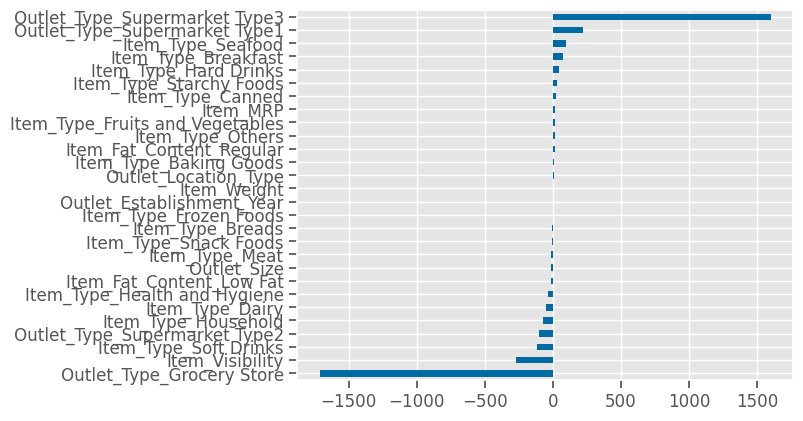

In [290]:
## Plot Coefficients
coef_df.sort_values().plot(kind='barh')

## Understanding Coefficients

Outlet_Type_Grocery Store         -1,714.27
Item_Visibility                     -268.41
Item_Type_Soft Drinks               -116.59
Outlet_Type_Supermarket Type2       -105.12
Item_Type_Household                  -69.72
Item_Type_Dairy                      -47.95
Item_Type_Health and Hygiene         -39.46
Item_Fat_Content_Low Fat             -15.38
Outlet_Size                          -13.28
Item_Type_Meat                       -12.46
Item_Type_Snack Foods                 -8.19
Item_Type_Breads                      -7.07
Item_Type_Frozen Foods                -2.36
Outlet_Establishment_Year              0.71
Item_Weight                            1.32
Outlet_Location_Type                   4.94
Item_Type_Baking Goods                 9.06
Item_Fat_Content_Regular              15.38
Item_Type_Others                      15.51
Item_Type_Fruits and Vegetables       15.52
Item_MRP                              15.60
Item_Type_Canned                      23.96
Item_Type_Starchy Foods         

<Axes: title={'center': 'All Coefficients - Ranked by Magnitude'}, xlabel='Coefficient', ylabel='Feature Names'>

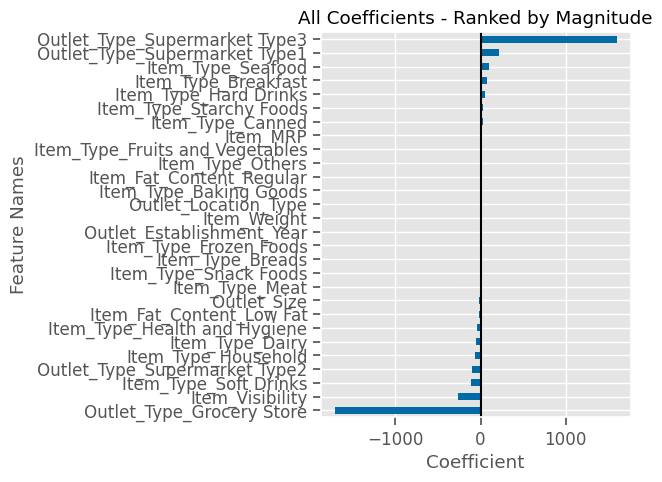

In [313]:
## Display Coefficients
display(coef_df.sort_values(ascending=True))
## Plot sorted Coefficients
plot_coefficients(coef_df)

In [310]:
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
coeff_rank

Outlet_Type_Grocery Store         28.00
Outlet_Type_Supermarket Type3     27.00
Item_Visibility                   26.00
Outlet_Type_Supermarket Type1     25.00
Item_Type_Soft Drinks             24.00
Outlet_Type_Supermarket Type2     23.00
Item_Type_Seafood                 22.00
Item_Type_Breakfast               21.00
Item_Type_Household               20.00
Item_Type_Dairy                   19.00
Item_Type_Hard Drinks             18.00
Item_Type_Health and Hygiene      17.00
Item_Type_Starchy Foods           16.00
Item_Type_Canned                  15.00
Item_MRP                          14.00
Item_Type_Fruits and Vegetables   13.00
Item_Type_Others                  12.00
Item_Fat_Content_Regular          11.00
Item_Fat_Content_Low Fat          10.00
Outlet_Size                        9.00
Item_Type_Meat                     8.00
Item_Type_Baking Goods             7.00
Item_Type_Snack Foods              6.00
Item_Type_Breads                   5.00
Outlet_Location_Type               4.00


In [311]:
top_n_features = coeff_rank.head(4)
top_n_features

Outlet_Type_Grocery Store       28.00
Outlet_Type_Supermarket Type3   27.00
Item_Visibility                 26.00
Outlet_Type_Supermarket Type1   25.00
dtype: float64

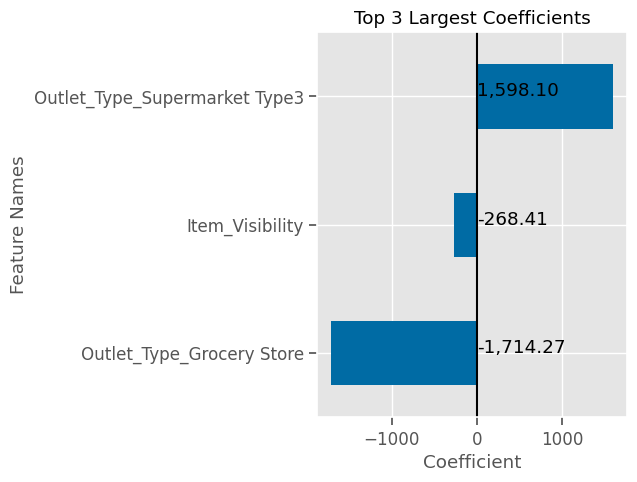

In [314]:
## Let's plot the 3 most impactful coefficients.
# plot coefficients
ax = plot_coefficients(coeffs,
                 top_n = 3,
                 intercept = False,
                 annotate = True);
ax.annotate("1,598.10", xy=(1,2));
ax.annotate("-268.41", xy=(1,1));
ax.annotate("-1,714.27", xy=(1,0));

In [379]:
import os

# Get the current working directory
cwd = os.getcwd()

# Normalize the path to the file you want to save to
normalized_path = os.path.normpath(os.path.join(cwd, 'top3largestcoefficientsmostimportant-features.png'))

# Save the figure to the normalized path
fig.savefig(normalized_path)


##  Interpret the coefficients

The three largest coefficients plotted are listed above. This means their coefficients can be interpreted as to how much the target changes. Target is sales prediction. The three categories as follows (largest to smallest):

* 1- Outlet_Type_Supermarket Type3 - the sales will increase by 1598.10 Rupees
* 2- Item_Visibility- the sales will decrease by 268.41 Rupees
* 3- Outlet_Type_Grocery Store - the sales will decrease by 1714.27 Rupees

##RandomForestRegressor Model

In [295]:
from sklearn.ensemble import RandomForestRegressor

In [296]:
## Create an instance of the model
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_proc, y_train)
evaluate_regression(rf_reg, X_train_proc, y_train,
                    X_test_proc, y_test)


Split,R^2,MAE,RMSE
Train,0.94,295.46,428.03
Test,0.56,819.78,"1,168.80"


In [297]:
# Extract Feature Importances
importances = rf_reg.feature_importances_
importances

array([0.01103772, 0.01025329, 0.00485238, 0.00492826, 0.00454638,
       0.00294916, 0.00249073, 0.00415835, 0.00577459, 0.00574415,
       0.00823377, 0.00288691, 0.00436201, 0.00642191, 0.00371895,
       0.00163484, 0.00147605, 0.00806335, 0.00411289, 0.0029498 ,
       0.19675819, 0.0026414 , 0.00184379, 0.05411927, 0.05313576,
       0.10124202, 0.44843324, 0.04123084])

In [298]:
# create a function to extract importances
def get_feature_importances(model):
    importances = model.feature_importances_
    feature_names = model.feature_names_in_
    return pd.Series(importances, index=feature_names)

In [299]:
# show importances Series
importances =  get_feature_importances(rf_reg)
importances

Outlet_Size                       0.0110
Outlet_Location_Type              0.0103
Item_Fat_Content_Low Fat          0.0049
Item_Fat_Content_Regular          0.0049
Item_Type_Baking Goods            0.0045
Item_Type_Breads                  0.0029
Item_Type_Breakfast               0.0025
Item_Type_Canned                  0.0042
Item_Type_Dairy                   0.0058
Item_Type_Frozen Foods            0.0057
Item_Type_Fruits and Vegetables   0.0082
Item_Type_Hard Drinks             0.0029
Item_Type_Health and Hygiene      0.0044
Item_Type_Household               0.0064
Item_Type_Meat                    0.0037
Item_Type_Others                  0.0016
Item_Type_Seafood                 0.0015
Item_Type_Snack Foods             0.0081
Item_Type_Soft Drinks             0.0041
Item_Type_Starchy Foods           0.0029
Outlet_Type_Grocery Store         0.1968
Outlet_Type_Supermarket Type1     0.0026
Outlet_Type_Supermarket Type2     0.0018
Outlet_Type_Supermarket Type3     0.0541
Item_Weight     

<Axes: >

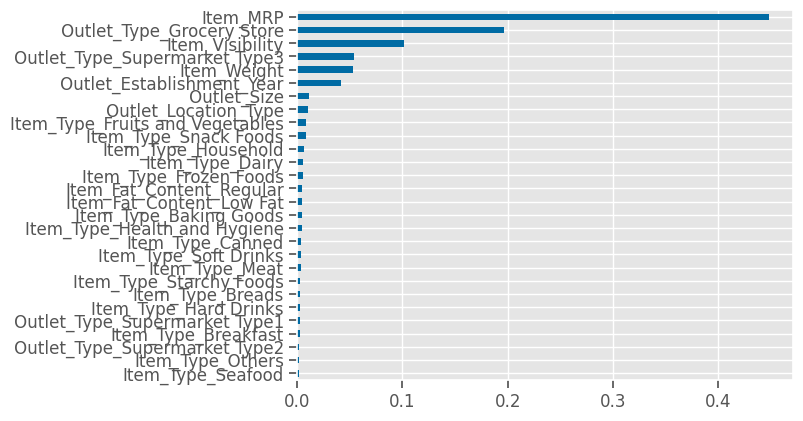

In [300]:
# Plot Importances
importances.sort_values().plot(kind='barh')

In [315]:
imp_rank = importances.abs().rank().sort_values(ascending=False)
imp_rank

Item_MRP                          28.00
Outlet_Type_Grocery Store         27.00
Item_Visibility                   26.00
Outlet_Type_Supermarket Type3     25.00
Item_Weight                       24.00
Outlet_Establishment_Year         23.00
Outlet_Size                       22.00
Outlet_Location_Type              21.00
Item_Type_Fruits and Vegetables   20.00
Item_Type_Snack Foods             19.00
Item_Type_Household               18.00
Item_Type_Dairy                   17.00
Item_Type_Frozen Foods            16.00
Item_Fat_Content_Regular          15.00
Item_Fat_Content_Low Fat          14.00
Item_Type_Baking Goods            13.00
Item_Type_Health and Hygiene      12.00
Item_Type_Canned                  11.00
Item_Type_Soft Drinks             10.00
Item_Type_Meat                     9.00
Item_Type_Starchy Foods            8.00
Item_Type_Breads                   7.00
Item_Type_Hard Drinks              6.00
Outlet_Type_Supermarket Type1      5.00
Item_Type_Breakfast                4.00


In [316]:
## Let's plot the 5 most important features
top_features = imp_rank.head(5)
top_features

Item_MRP                        28.00
Outlet_Type_Grocery Store       27.00
Item_Visibility                 26.00
Outlet_Type_Supermarket Type3   25.00
Item_Weight                     24.00
dtype: float64

In [317]:
## Slicing out the top_n_features names to visualize
plot_vals = coeffs.loc[top_features.index]
plot_vals

Item_MRP                            15.60
Outlet_Type_Grocery Store       -1,714.27
Item_Visibility                   -268.41
Outlet_Type_Supermarket Type3    1,598.10
Item_Weight                          1.32
dtype: float64

In [326]:
## Saving the feature importances sorted from largest to smallest (ascending=False)
sorted_importance = importances.sort_values(ascending=False)
sorted_importance

Item_MRP                          0.45
Outlet_Type_Grocery Store         0.20
Item_Visibility                   0.10
Outlet_Type_Supermarket Type3     0.05
Item_Weight                       0.05
Outlet_Establishment_Year         0.04
Outlet_Size                       0.01
Outlet_Location_Type              0.01
Item_Type_Fruits and Vegetables   0.01
Item_Type_Snack Foods             0.01
Item_Type_Household               0.01
Item_Type_Dairy                   0.01
Item_Type_Frozen Foods            0.01
Item_Fat_Content_Regular          0.00
Item_Fat_Content_Low Fat          0.00
Item_Type_Baking Goods            0.00
Item_Type_Health and Hygiene      0.00
Item_Type_Canned                  0.00
Item_Type_Soft Drinks             0.00
Item_Type_Meat                    0.00
Item_Type_Starchy Foods           0.00
Item_Type_Breads                  0.00
Item_Type_Hard Drinks             0.00
Outlet_Type_Supermarket Type1     0.00
Item_Type_Breakfast               0.00
Outlet_Type_Supermarket T

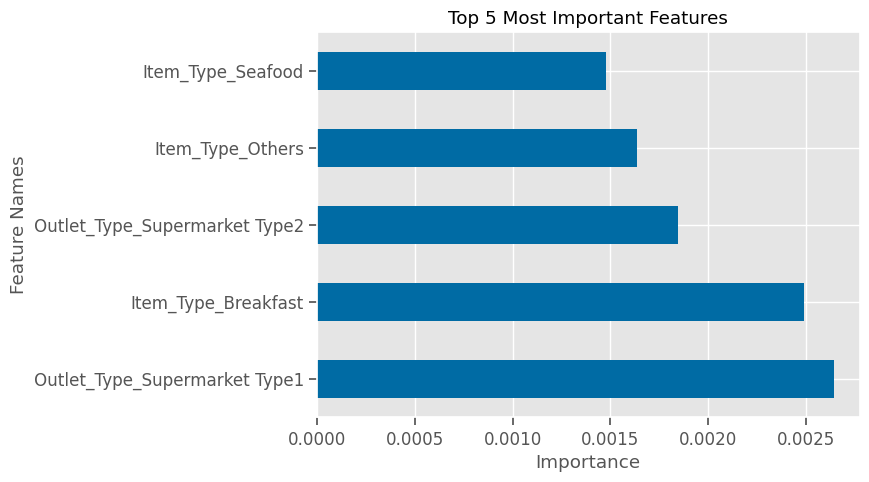

In [335]:
## plotting top 10 importances
ax = sorted_importance.tail(5).plot(kind='barh',
                                   figsize=(7,5),)
ax.set(xlabel='Importance',
        ylabel='Feature Names',
        title='Top 5 Most Important Features');

In [336]:
## Saving figure
ax

<Axes: title={'center': 'Top 5 Most Important Features'}, xlabel='Importance', ylabel='Feature Names'>

In [337]:
## using the ax to get the fig
fig_ax = ax.get_figure()

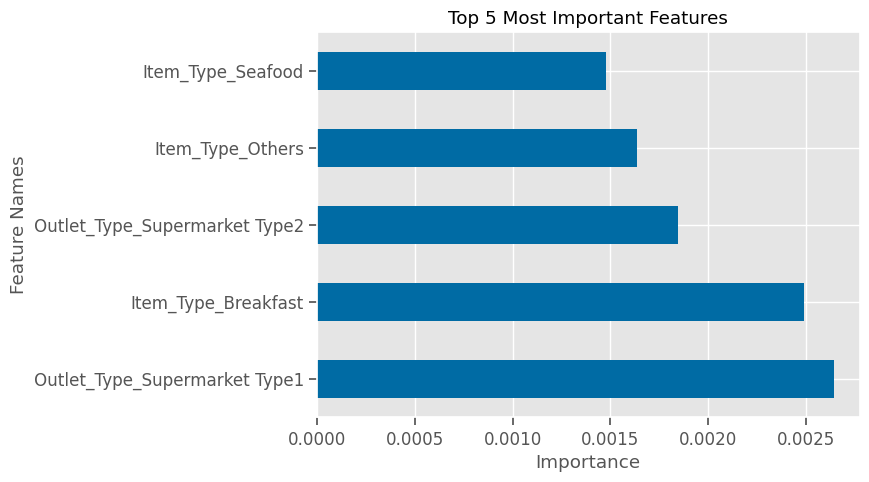

In [338]:
fig_ax

##Interpret

Top 5 most important features:
* Outlet_Type_supermarket Type1
* Item_Type_Breakfast
* Outlet_Type_Supermarket Type2
* Item_Type_Others
* Item_Type_Seafood


In [371]:
import os

# Get the current working directory
cwd = os.getcwd()

# Normalize the path to the file you want to save to
normalized_path = os.path.normpath(os.path.join(cwd, 'top5mostimportant-features.png'))

# Save the figure to the normalized path
fig.savefig(normalized_path)




###**Using joblib to Save our Model**

In [372]:
X_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
8269,FDI60,7.22,Regular,0.06,Baking Goods,61.25,OUT010,1998,NaN,Tier 3,Grocery Store
7604,DRD25,6.13,Low Fat,0.08,Soft Drinks,111.29,OUT018,2009,Medium,Tier 3,Supermarket Type2
2762,NCP18,12.15,Low Fat,0.03,Household,151.07,OUT035,2004,Small,Tier 2,Supermarket Type1
6464,NCS30,5.95,Low Fat,0.09,Household,127.87,OUT035,2004,Small,Tier 2,Supermarket Type1
4707,FDI08,18.20,Regular,0.07,Fruits and Vegetables,247.21,OUT035,2004,Small,Tier 2,Supermarket Type1


In [373]:
import joblib, os

## creating a dictionary of all of the variables to save for later
to_save = {'X_train': X_train,
          'X_test':X_test,
          'y_train':y_train,
          'y_test':y_test,
          'preprocessor':preprocessor,
          'RandomForestRegressor':rf_reg,
          'LinearRegression':linreg,
          'preprocessor':preprocessor}

In [374]:
# Create the folder to save it in
folder = '../Models/'
filename = "best-models.joblib"
os.makedirs(folder, exist_ok=True)

In [375]:
# Save the models, data, and preprocessor
joblib.dump(to_save, folder + filename)

['../Models/best-models.joblib']

In [376]:
# try loading again to make sure it works.

saved_stuff = joblib.load(folder + filename)
saved_stuff.keys()

dict_keys(['X_train', 'X_test', 'y_train', 'y_test', 'preprocessor', 'RandomForestRegressor', 'LinearRegression'])